# Trabajo de fin de grado

Se importan las librerias necesarias, en primer lugar algunas librerias para tratar con los tipos de datos

In [1]:
import pandas as pd
import numpy as np
import math

Se importan tambien los algoritmos que se utilizaran más adelante para predecir

In [2]:
from sklearn.model_selection  import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Librerias para el preprocesado y analisis de los datos

In [3]:
#Utilizados para normalizar
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler

#Para la seleccion de variables
import sklearn.feature_selection
from sklearn.decomposition import PCA
from sklearn import preprocessing

Y otras de ayuda para plotear gráficas y mostrar métricas

In [4]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

## Datos de audios

Se comienza con la carga de los archivos .csv que han de encontrarse en el mismo directorio. Como se ve en el código cuando el valor no está definido aparece *--undefined--* y por ello esos valores son tratados como NA's

In [5]:
audiosMezclados = pd.read_csv('csv/audios/sonidosMezclados.csv', na_values='--undefined--')
audiosAleman = pd.read_csv('csv/audios/sonidosAleman.csv', na_values='--undefined--')
audiosEspanol = pd.read_csv('csv/audios/sonidosEspanol.csv', na_values='--undefined--')

Observando los cantidad de audios de las diferentes clases que se encuentran en cada uno de los dataframes, es fácil ver que en dataframe de audios en Español hay una presencia muy elevada de audios neutrales, por ello a continuación se eliminan varios de ellos de forma que finalmente todos estén presentes en la misma proporción

In [6]:
neutrales = audiosEspanol[audiosEspanol['Result']==5]
audiosEspanol = audiosEspanol.drop(np.arange((neutrales.index[0]+184),neutrales.index[-1]+1))
audiosEspanol = audiosEspanol.reset_index(drop=True)

A continuación se separan los dataframes en dos, uno con los datos de entrenamiento y otro con la etiqueta de cada ejemplo

In [7]:
X_Mezclados = audiosMezclados.drop(['Result'], axis=1)
y_Mezclados = audiosMezclados.Result

X_Aleman = audiosAleman.drop(['Result'], axis=1)
y_Aleman = audiosAleman.Result

X_Espanol = audiosEspanol.drop(['Result'], axis=1)
y_Espanol = audiosEspanol.Result

Se definen unas funciones utiles para normalizar los datos de entrenamiento y las pruebas que se realizan más adelante; junto con otras para eliminar valores faltantes con la media.

In [8]:
def calcularMediaYDesviacion(df):
    mean = df.mean(numeric_only=1)
    std = df.std(numeric_only=1)
    return mean,std
def normalizar(df, mean, std):
    df = np.subtract(df,np.expand_dims(mean,axis=0))
    df = np.divide(df,np.expand_dims(std,axis=0))
    return df
def normalizarPrueba(df,mean,std):
    df = np.subtract(df,np.expand_dims(mean,axis=0))
    df = np.divide(df,np.expand_dims(std,axis=0))
    return df

In [9]:
def deleteNAWithMean(df,mean):
    for i in df.columns.values:
        df[i].replace(np.nan, mean[i], inplace = True)
    return df

Dado que existen varios valores nulos, se reemplazan con la media de la columna a la que pertenecen

In [10]:
meanMezclados, stdMezclados = calcularMediaYDesviacion(X_Mezclados)
meanAleman, stdAleman = calcularMediaYDesviacion(X_Aleman)
meanEspanol, stdEspanol = calcularMediaYDesviacion(X_Espanol)

In [11]:
X_Mezclados = deleteNAWithMean(X_Mezclados,meanMezclados)
X_Aleman = deleteNAWithMean(X_Aleman,meanAleman)
X_Espanol = deleteNAWithMean(X_Espanol,meanEspanol)

Para realizar un analisis sobre la correlación que existe entre las variables, se muestran algunos mapas de calor en los que existe al menos un par de variables con una correlación absoluta mayor a 0.8, para después valorar la eliminación de alguna de esas variables con la finalidad de reducir los datos de entrenamiento necesarios

/home/jose/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


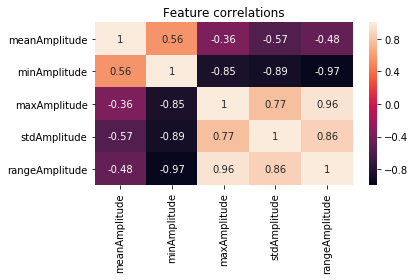

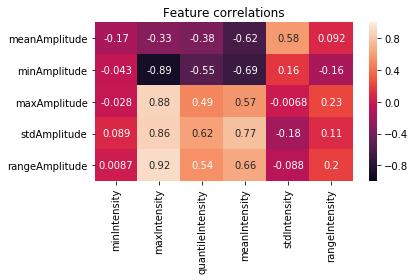

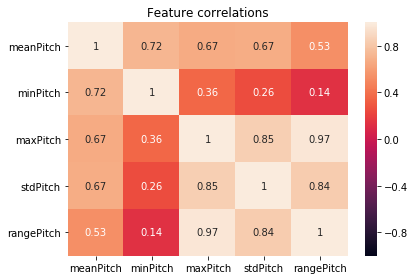

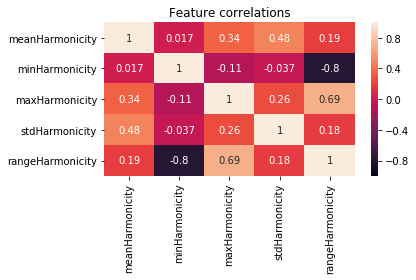

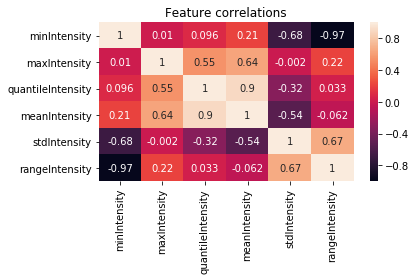

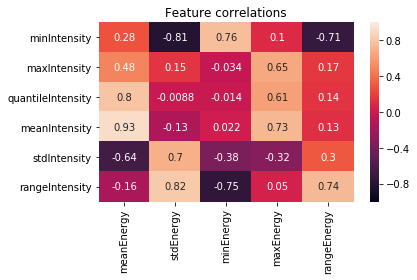

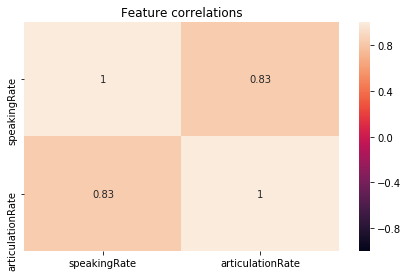

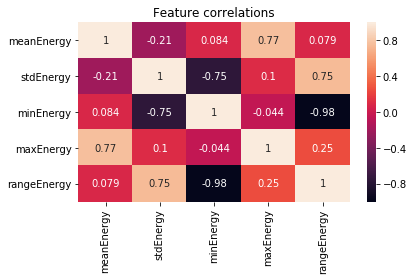

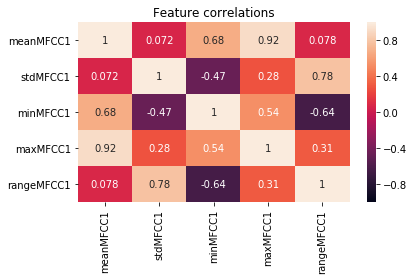

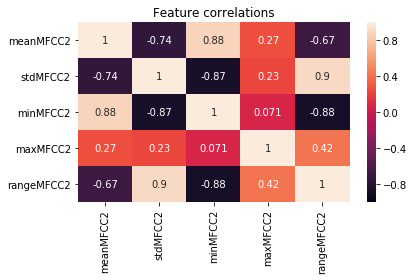

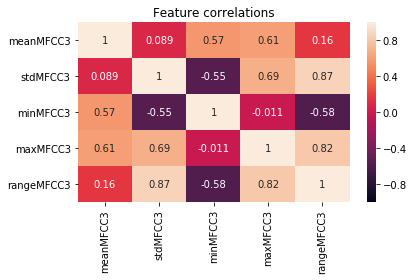

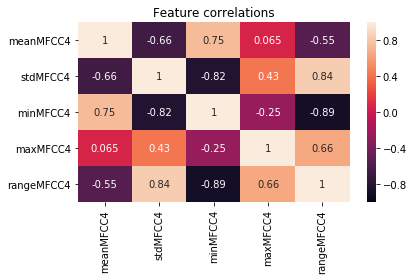

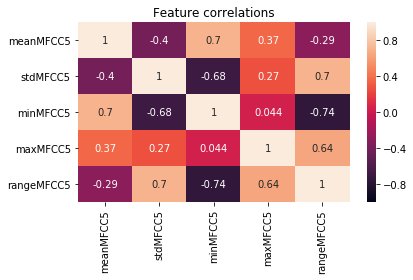

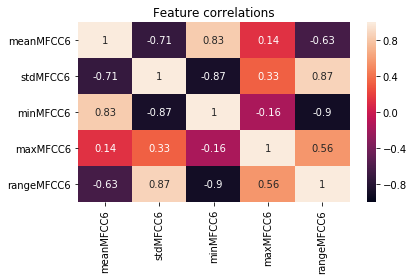

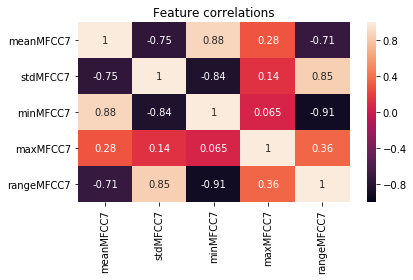

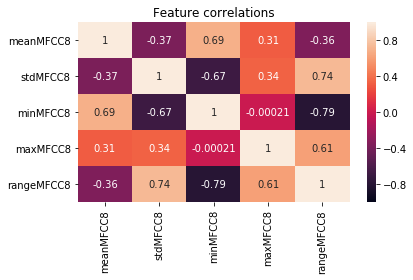

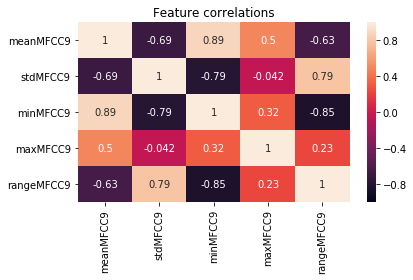

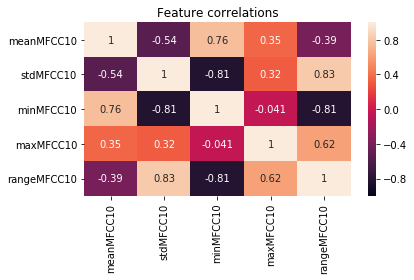

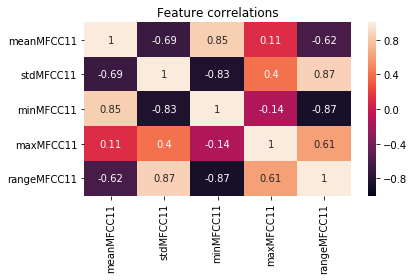

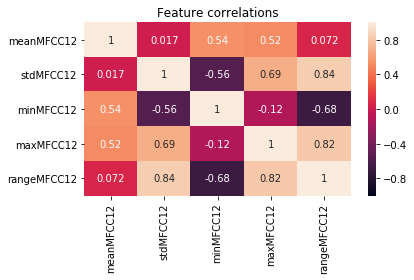

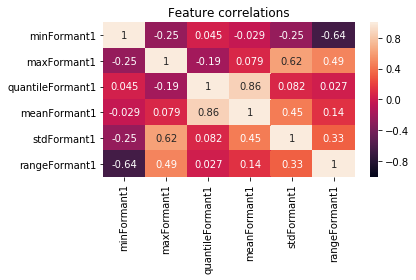

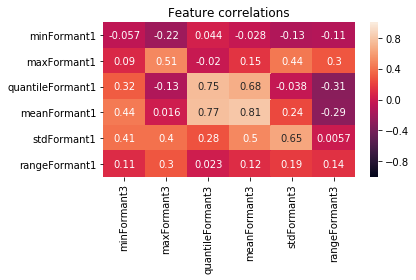

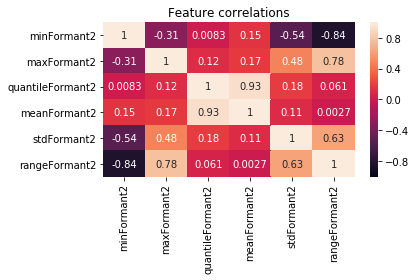

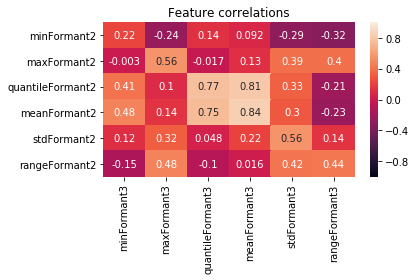

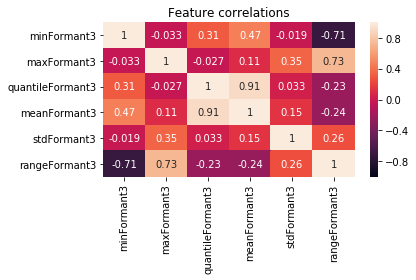

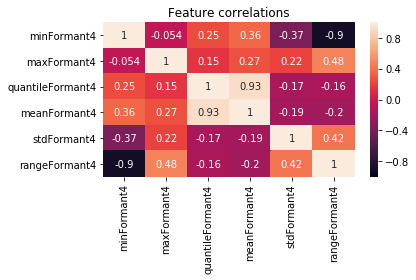

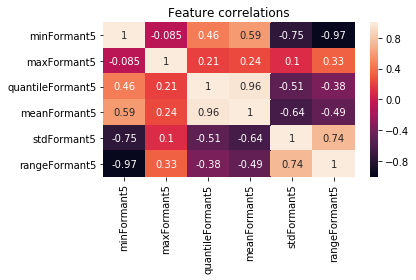

In [12]:
correlation = X_Mezclados.corr()
limites = [0,5,10,15,21,23,28,33,38,43,48,53,58,63,68,73,78,83,88,94,100,106,112,118]
for i in range(0,len(limites)-1):
    for j in range(i,len(limites)-1):
        correlation = correlation.iloc[limites[i]:limites[i+1],limites[j]:limites[j+1]]
        if(np.any(correlation<-0.8) or np.any(correlation>0.8)):
            plt.figure()
            sns.heatmap(correlation, xticklabels = correlation.columns.values,
                        yticklabels=correlation.index.values, vmin=-1,vmax=1,annot=True)
            plt.title('Feature correlations')
            plt.tight_layout()
            plt.savefig(correlation.columns.values[0] + correlation.index.values[0])
        correlation = X_Mezclados.corr()

### Normalizar datos

Se definen varios métodos para normalizar con el objetivo de poder comparar los resultados que producen cada una de ellas

Normalización utilizando el método MinMax, que convierte los valores a un intervalo de 0-1

In [13]:
scaler = MinMaxScaler()
scalerMezclados = scaler.fit(X_Mezclados)
scalerAleman = scaler.fit(X_Aleman)
scalerEspanol = scaler.fit(X_Espanol)
minMaxScaled_Mezclados = scalerMezclados.transform(X_Mezclados)
minMaxScaled_Aleman = scalerAleman.transform(X_Aleman)
minMaxScaled_Espanol = scalerEspanol.transform(X_Espanol)

Normalización ZScore, para transformar los datos a una normal

In [14]:
normalizar_Mezclados = normalizar(X_Mezclados,meanMezclados,stdMezclados)
normalizar_Aleman = normalizar(X_Aleman,meanAleman,stdAleman)
normalizar_Espanol = normalizar(X_Espanol,meanEspanol,stdEspanol)

Normalización utilizando la norma l1, l2 o max, según se especifique en los argumentos

In [15]:
normalized_Mezclados, normMezclados = normalize(X_Mezclados, norm = 'l2',axis=0,return_norm=True)
normalized_Aleman, normAleman = normalize(X_Aleman, norm='l2',axis=0,return_norm=True)
normalized_Espanol, normEspanol = normalize(X_Espanol, norm='l2',axis=0,return_norm=True)

Normalización realizada con el rango interquartílico, de forma que sea más robusta frente a valores atípicos

In [16]:
robustScaler = RobustScaler()
robustScalerMezclados = robustScaler.fit(X_Mezclados)
robustScalerAleman = robustScaler.fit(X_Aleman)
robustScalerEspanol = robustScaler.fit(X_Espanol)
robustScaled_Mezclados = robustScalerMezclados.transform(X_Mezclados)
robustScaled_Aleman = robustScalerAleman.transform(X_Aleman)
robustScaled_Espanol = robustScalerEspanol.transform(X_Espanol)

### Seleccionar datos para entrenar

Para facilitar la selección de los datos se ponen a disposicion asignaciones de todas las normalizaciones de los datos, de forma que bastará con descomentar las asignaciones que se quieran realizar

In [17]:
#opN=1
#X_MezcladosNor, scalerM = pd.DataFrame(minMaxScaled_Mezclados, columns = X_Mezclados.columns.values), scalerMezclados
#X_AlemanNor, scalerA = pd.DataFrame(minMaxScaled_Aleman, columns = X_Aleman.columns.values), scalerAleman
#X_EspanolNor, scalerE = pd.DataFrame(minMaxScaled_Espanol, columns = X_Espanol.columns.values), scalerEspanol

opN=2
X_MezcladosNor = pd.DataFrame(normalizar_Mezclados)
X_AlemanNor = pd.DataFrame(normalizar_Aleman)
X_EspanolNor = pd.DataFrame(normalizar_Espanol)

#opN=3
#X_MezcladosNor = pd.DataFrame(normalized_Mezclados, columns = X_Mezclados.columns.values)
#X_AlemanNor = pd.DataFrame(normalized_Aleman, columns = X_Aleman.columns.values)
#X_EspanolNor = pd.DataFrame(normalized_Espanol, columns = X_Espanol.columns.values)

#opN=4
#X_MezcladosNor, scalerM = pd.DataFrame(robustScaled_Mezclados, columns = X_Mezclados.columns.values), robustScalerMezclados
#X_AlemanNor, scalerA = pd.DataFrame(robustScaled_Aleman, columns = X_Aleman.columns.values), robustScalerAleman
#X_EspanolNor, scalerE = pd.DataFrame(robustScaled_Espanol, columns = X_Espanol.columns.values), robustScalerEspanol

### Seleccion de variables

Para seleccionar variables a eliminar, a parte de utilizar el analisis que se hizo anteriormente en base a las correlaciones; se lanza un algoritmo de decisión para que establezca un orden en la importancia de las variables. Así las variables que el arbol considere menos importantes se podrán eliminar, al igual que las que considere más importantes se procurará mantenerlas 

In [18]:
model = ExtraTreesClassifier(n_estimators=90)
model = model.fit(X_MezcladosNor,y_Mezclados)
featureImportance = model.feature_importances_
print(featureImportance)
featureImportance = np.argsort(featureImportance)
print(featureImportance)

[0.01445527 0.01050103 0.00882317 0.01232678 0.00927386 0.02576061
 0.01588372 0.01761612 0.01690156 0.01187023 0.01097855 0.00382381
 0.00353092 0.00757452 0.00348411 0.02178899 0.00918285 0.00826358
 0.00849508 0.00709347 0.01511391 0.00726868 0.00806443 0.0083692
 0.0069765  0.01551851 0.00550541 0.00758166 0.01019803 0.00652594
 0.00718986 0.01032097 0.00670042 0.01572413 0.01313091 0.01379124
 0.00570672 0.00912542 0.00740301 0.00751508 0.00845222 0.00634218
 0.00591354 0.01179292 0.00909035 0.00555366 0.00512594 0.0042389
 0.01483722 0.0112133  0.00718076 0.00398039 0.00434031 0.00939031
 0.00751928 0.00799231 0.00469178 0.00482298 0.01085906 0.02182156
 0.00755989 0.00603804 0.00818653 0.00605303 0.00597557 0.00549119
 0.00516082 0.00387671 0.01329877 0.00816008 0.00746278 0.00461935
 0.00432662 0.02013314 0.00860262 0.0108899  0.01212237 0.0051075
 0.00846872 0.00678807 0.00548667 0.00639145 0.00516053 0.01252327
 0.00915754 0.00555737 0.00552147 0.00462724 0.00230631 0.0037777

Tras entrenar con el arbol, se implementa un metodo que devuelve las variables más o menos importantes, en función del signo del parámetro de entrada

In [19]:
def moreImportantFeatures(how_many, classifier, inputData, outputData):
    model = classifier.fit(inputData,outputData)
    featureImportance = model.feature_importances_
    orderImportance = np.argsort(featureImportance)
    if(how_many >=0):
        for i in range(1,how_many):
            print(inputData.columns.values[orderImportance[-i]])
    else:
        for i in range(1,-how_many):
            print(inputData.columns.values[orderImportance[i]])

In [20]:
moreImportantFeatures(-20, ExtraTreesClassifier(n_estimators=90),X_MezcladosNor,y_Mezclados)

rangeFormant1
maxFormant5
rangeHarmonicity
maxFormant4
maxMFCC5
maxFormant2
minHarmonicity
maxHarmonicity
rangeMFCC8
maxFormant1
rangeMFCC4
rangeMFCC9
rangeFormant4
rangeMFCC11
meanFormant2
maxMFCC6
maxFormant3
rangeMFCC12
rangeMFCC6


A continuación se crean varios conjuntos eliminando algunas variables. En uno de ellos eliminamos variables que tenian más de un 0.8 de correlación absoluta; otro eliminando aquellas variables que el arbol de decisión determina que son menos influyentes y un ultimo eliminando variables que cumplan alguna de las condiciones

In [21]:
X_MezcladosNor80 = X_MezcladosNor.drop(['meanEnergy','minEnergy','rangeEnergy','stdEnergy','rangeAmplitude','minMFCC1','stdMFCC1','rangeMFCC2','rangeMFCC4','rangeMFCC12','maxPitch','stdPitch','quantileFormant1','quantileFormant2','rangeFormant2','quantileFormant3','quantileFormant4','rangeFormant4','rangeFormant5','quantileFormant5','stdAmplitude','articulationRate','meanIntensity'], axis=1)
X_AlemanNor80 = X_AlemanNor.drop(['meanEnergy','minEnergy','rangeEnergy','stdEnergy','rangeAmplitude','minMFCC1','stdMFCC1','rangeMFCC2','rangeMFCC4','rangeMFCC12','maxPitch','stdPitch','quantileFormant1','quantileFormant2','rangeFormant2','quantileFormant3','quantileFormant4','rangeFormant4','rangeFormant5','quantileFormant5','stdAmplitude','articulationRate','meanIntensity'], axis=1)
X_EspanolNor80 = X_EspanolNor.drop(['meanEnergy','minEnergy','rangeEnergy','stdEnergy','rangeAmplitude','minMFCC1','stdMFCC1','rangeMFCC2','rangeMFCC4','rangeMFCC12','maxPitch','stdPitch','quantileFormant1','quantileFormant2','rangeFormant2','quantileFormant3','quantileFormant4','rangeFormant4','rangeFormant5','quantileFormant5','stdAmplitude','articulationRate','meanIntensity'], axis=1)

In [22]:
X_MezcladosNorLessImportant = X_MezcladosNor.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant2','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
X_AlemanNorLessImportant = X_AlemanNor.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant2','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
X_EspanolNorLessImportant = X_EspanolNor.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant2','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)

In [23]:
X_MezcladosNor80LessImportant = X_MezcladosNor80.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
X_AlemanNor80LessImportant = X_AlemanNor80.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
X_EspanolNor80LessImportant = X_EspanolNor80.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)

In [24]:
def histogramas(data):
    for nameOfColumn in data.columns.values:
        data.hist(nameOfColumn)

/home/jose/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


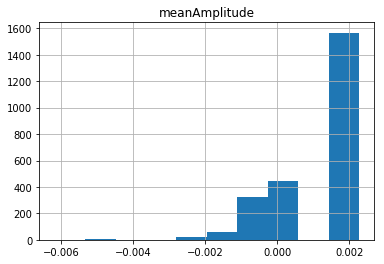

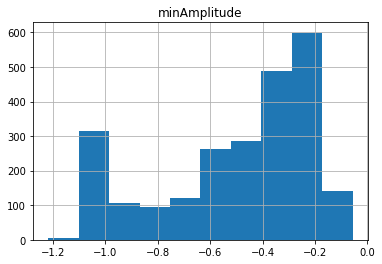

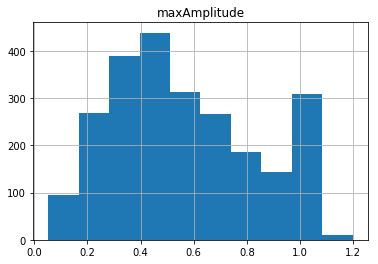

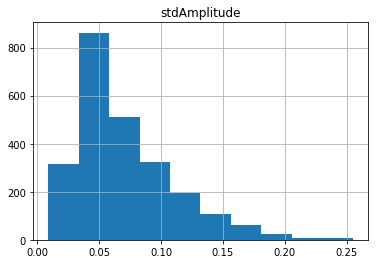

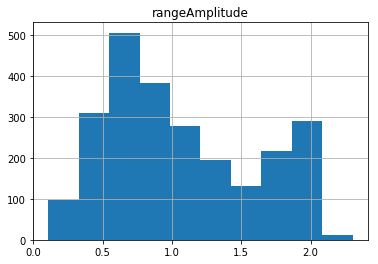

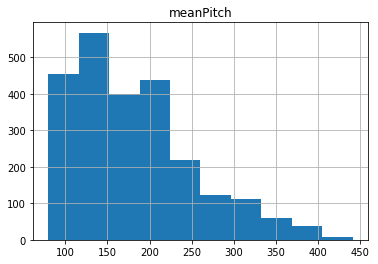

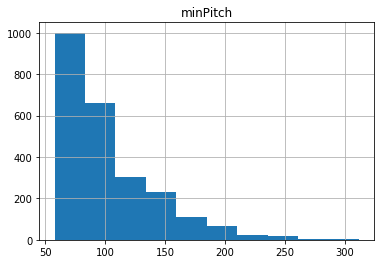

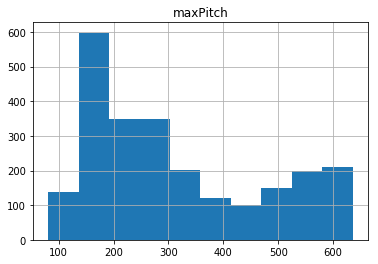

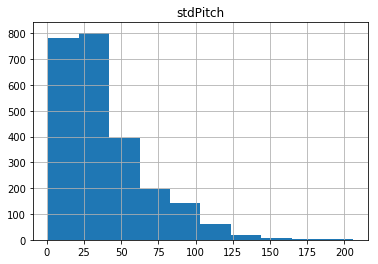

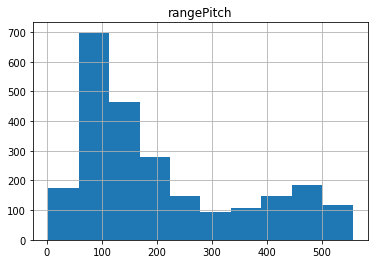

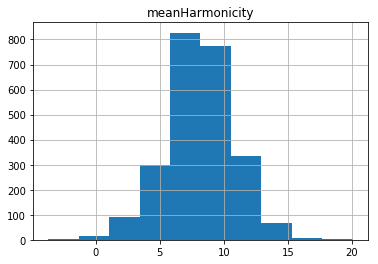

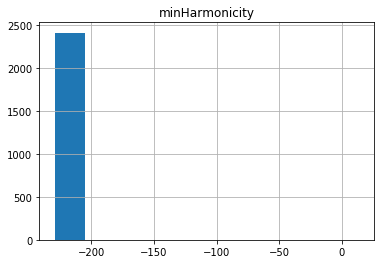

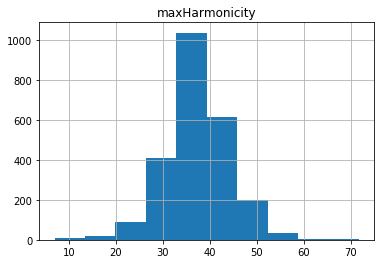

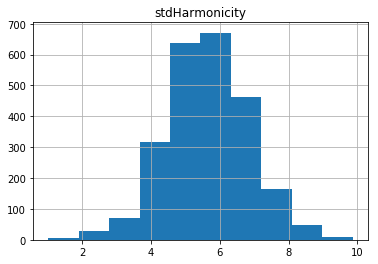

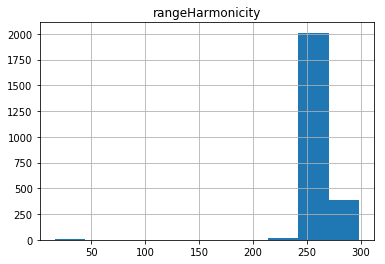

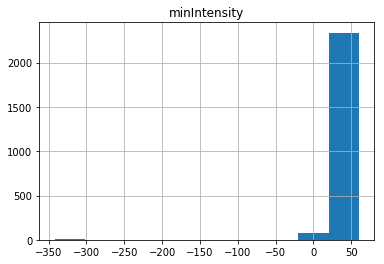

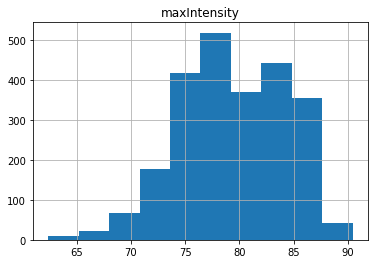

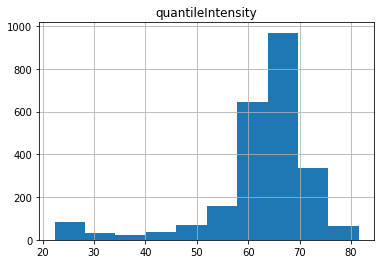

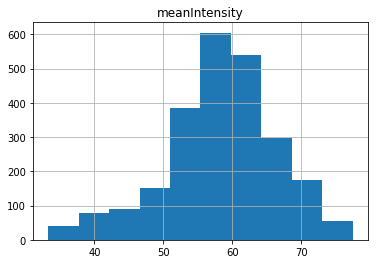

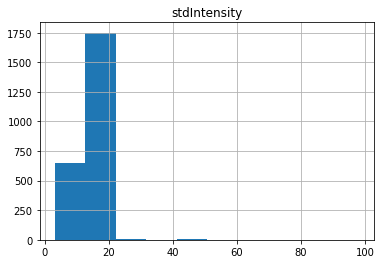

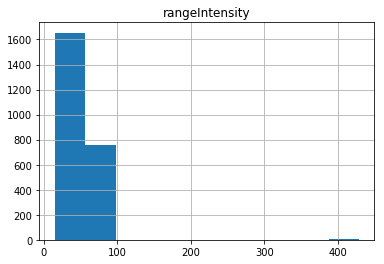

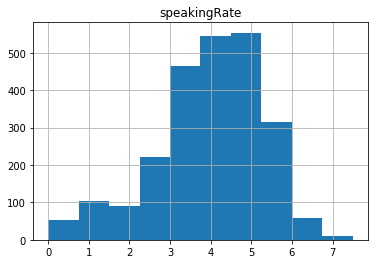

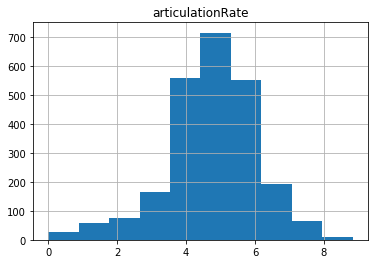

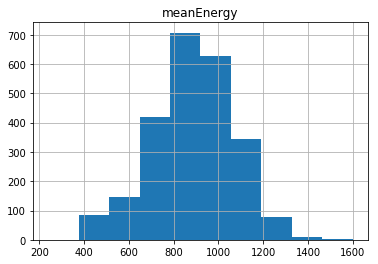

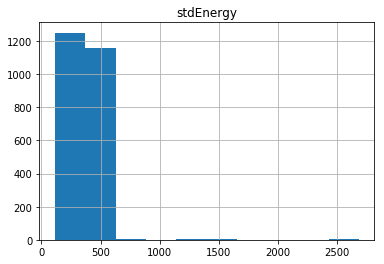

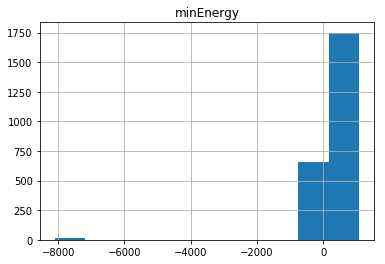

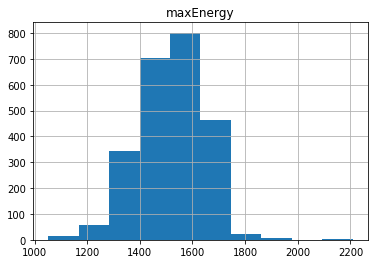

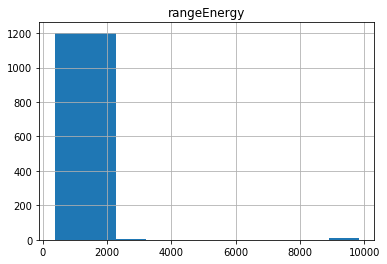

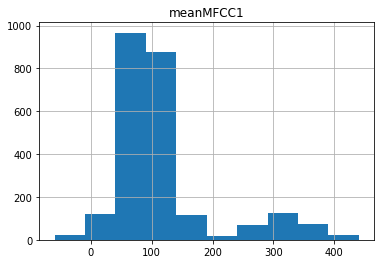

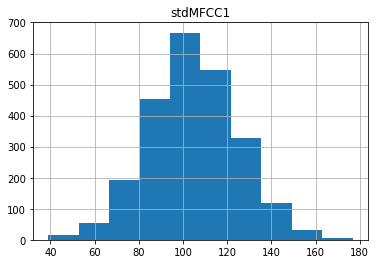

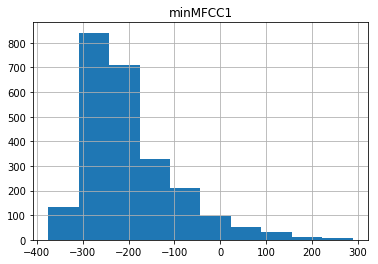

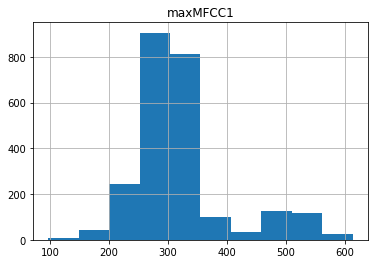

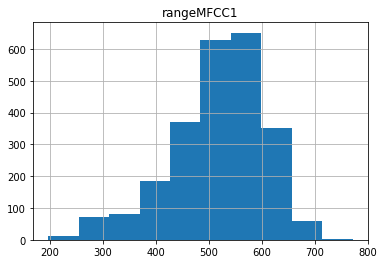

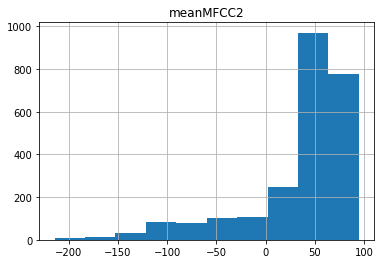

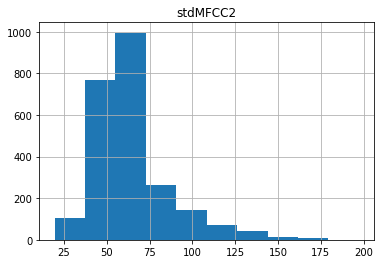

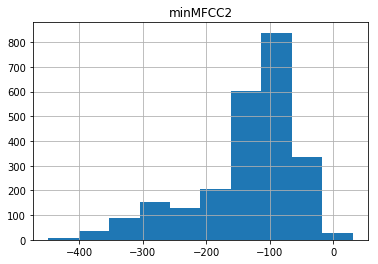

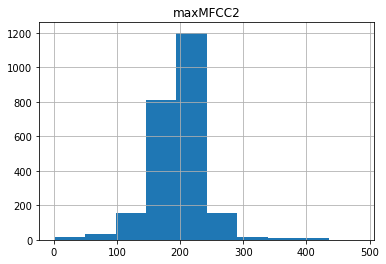

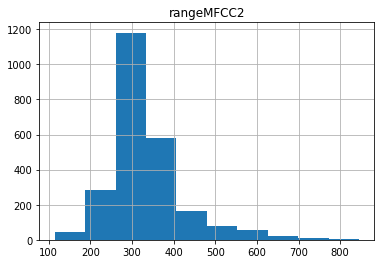

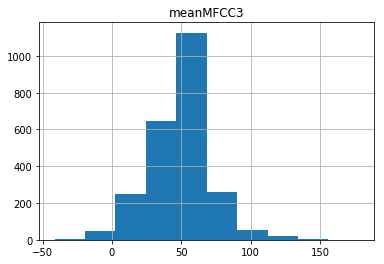

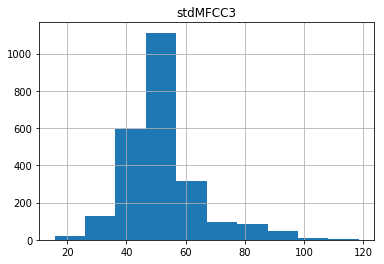

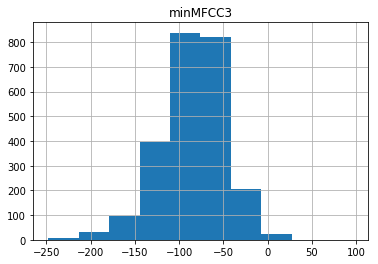

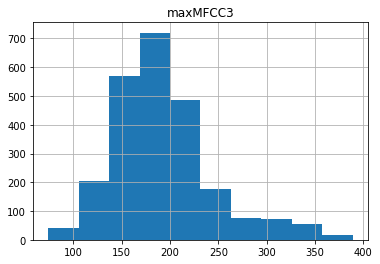

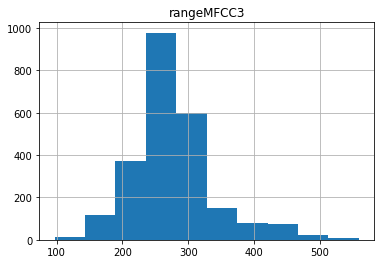

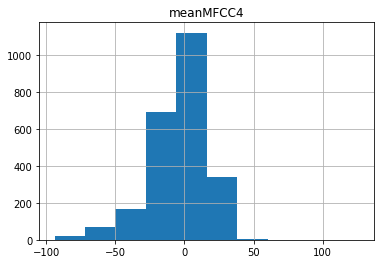

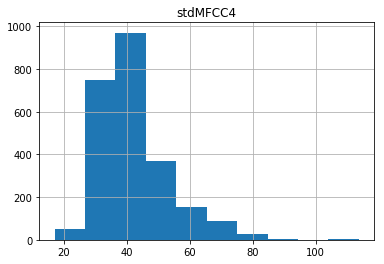

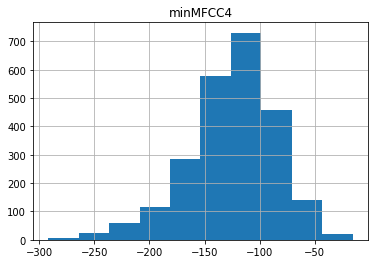

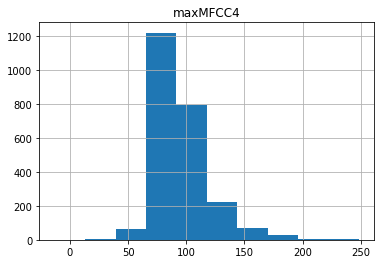

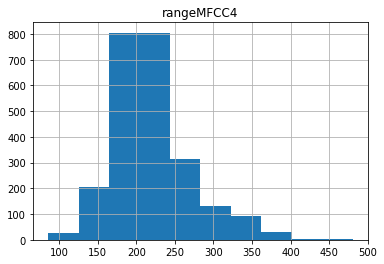

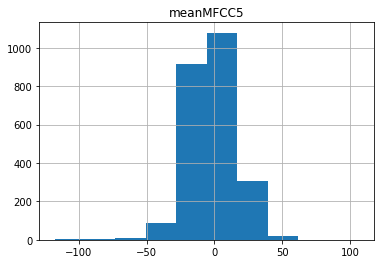

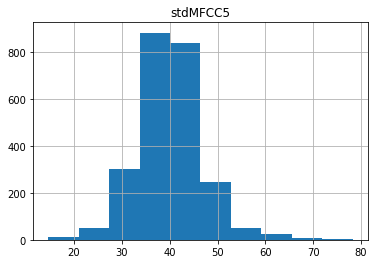

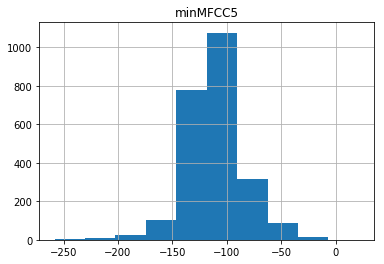

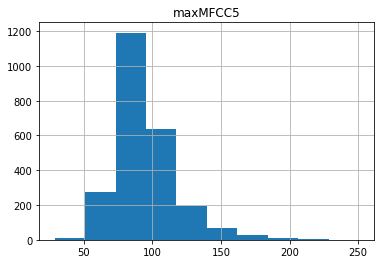

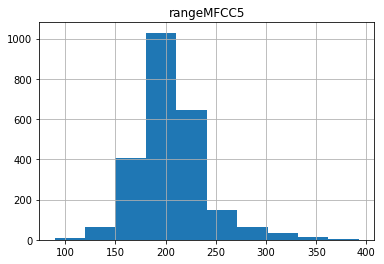

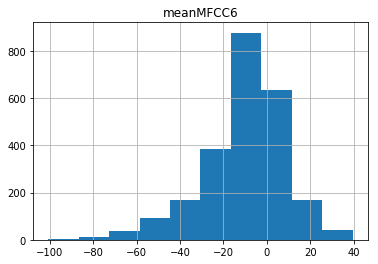

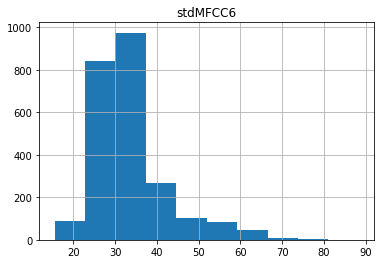

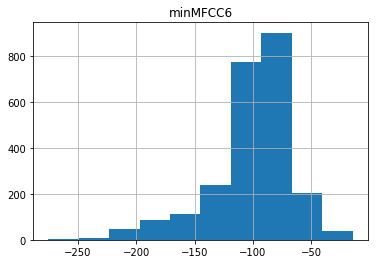

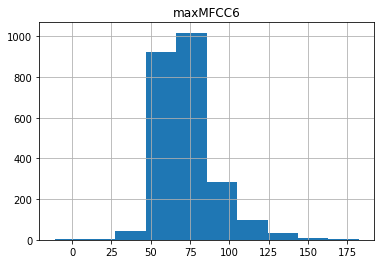

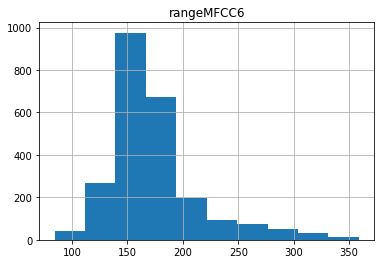

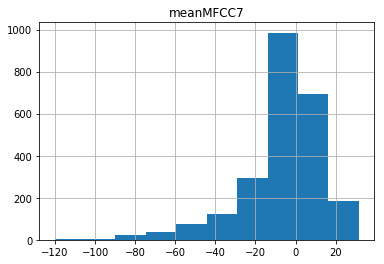

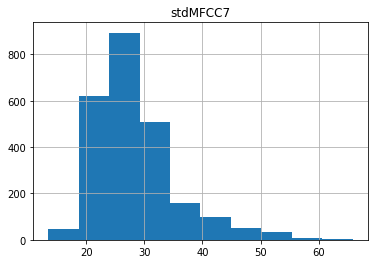

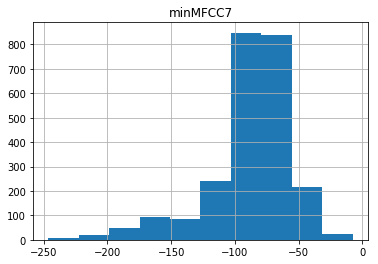

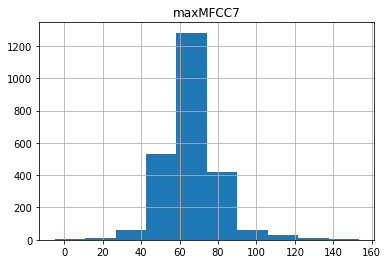

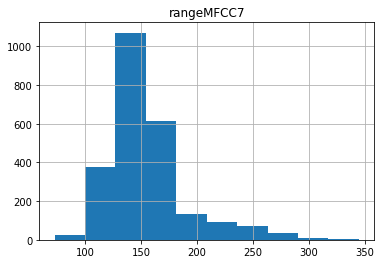

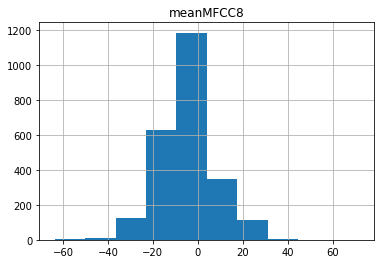

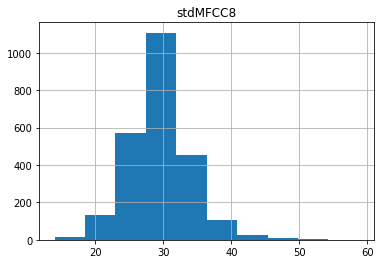

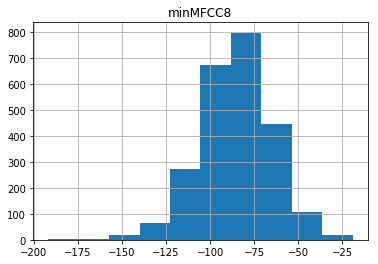

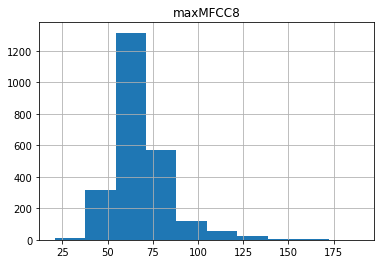

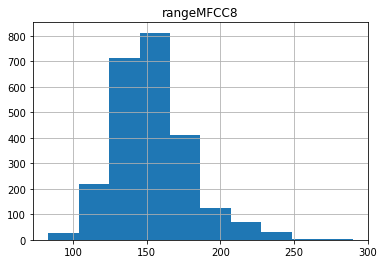

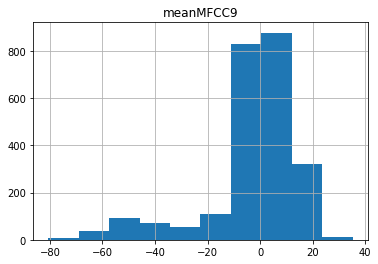

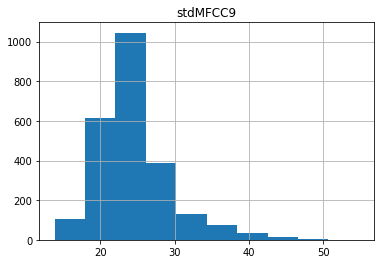

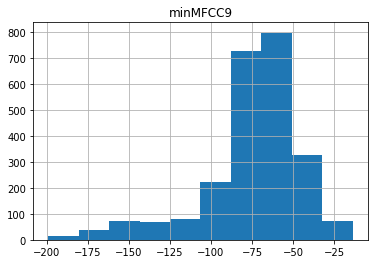

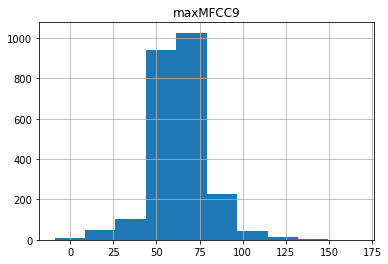

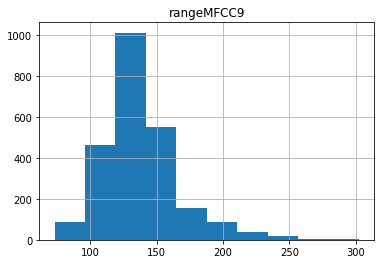

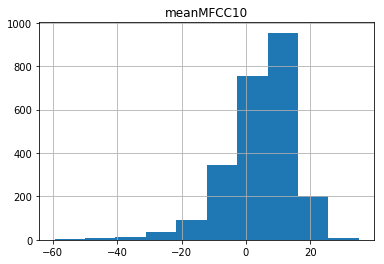

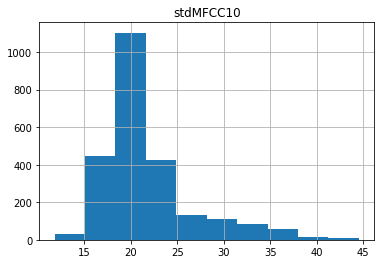

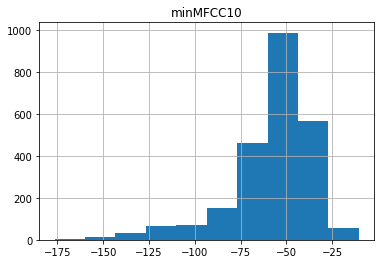

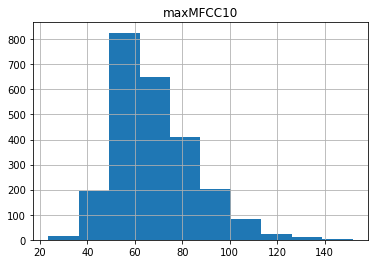

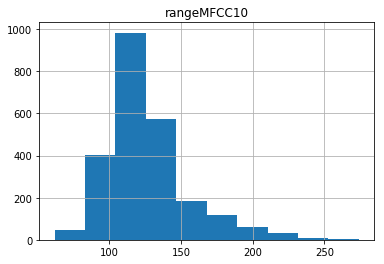

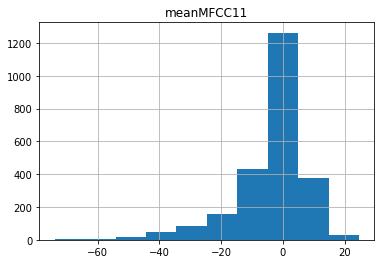

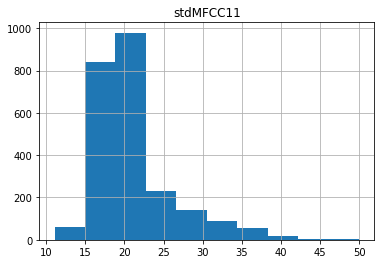

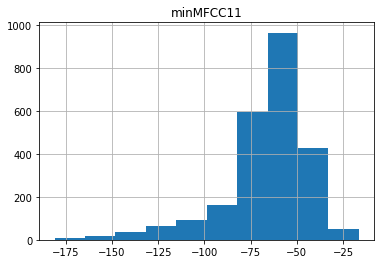

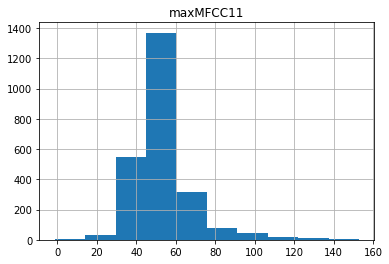

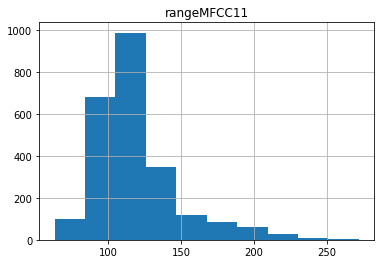

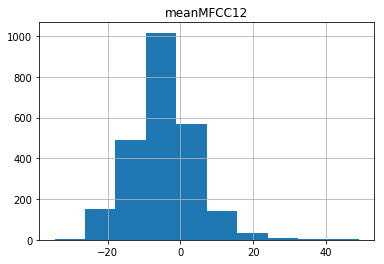

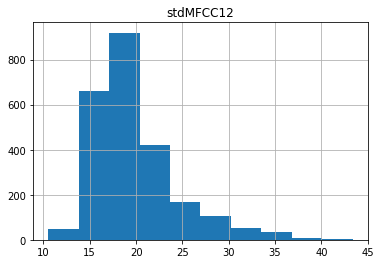

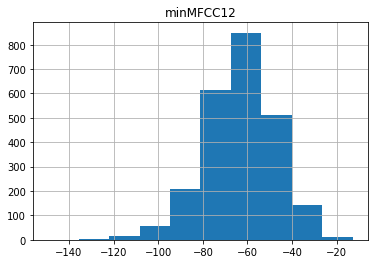

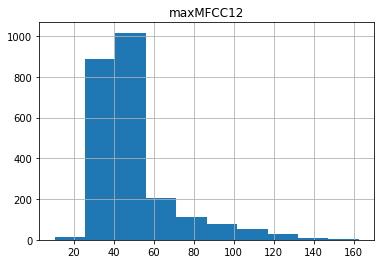

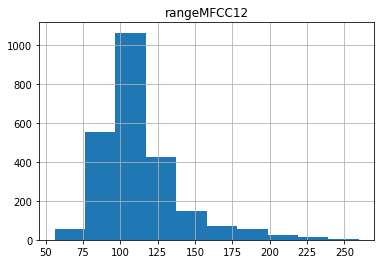

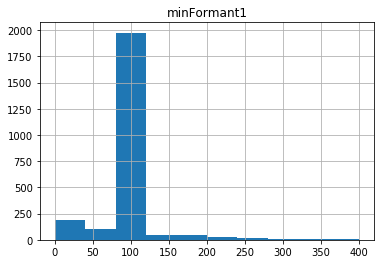

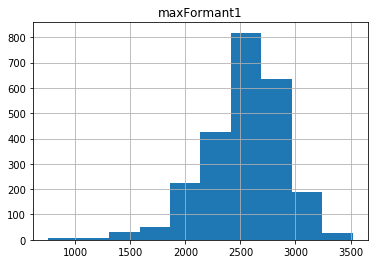

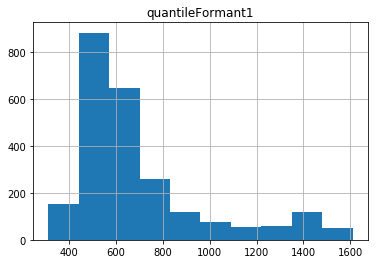

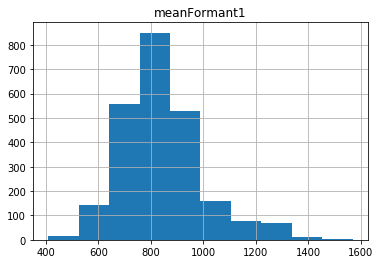

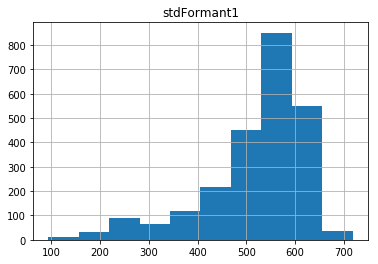

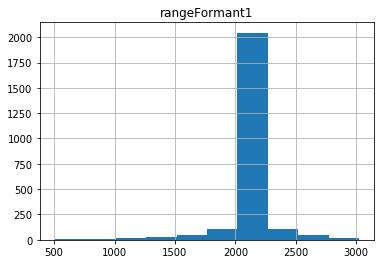

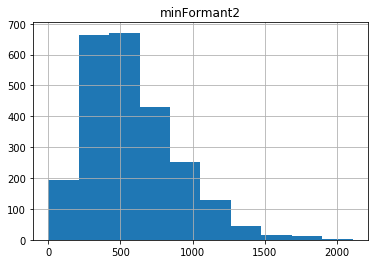

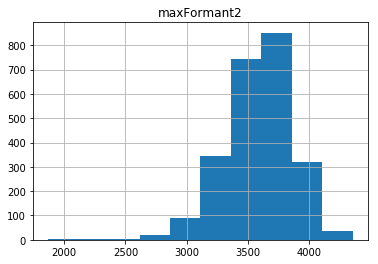

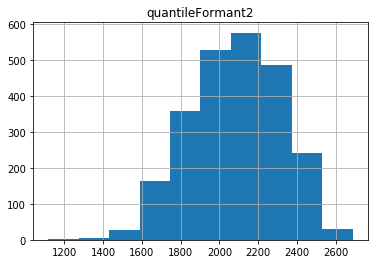

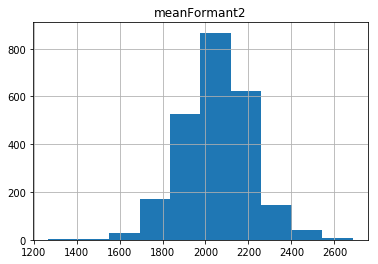

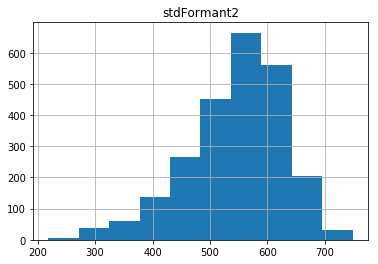

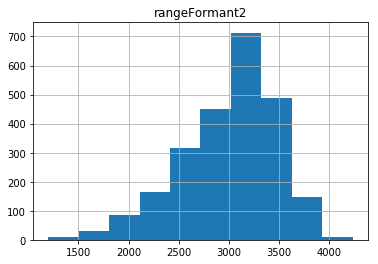

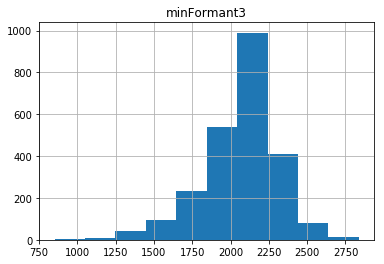

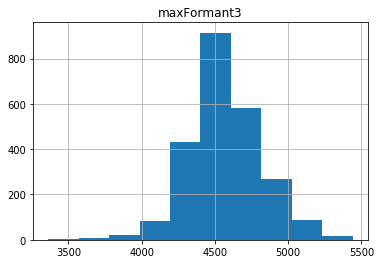

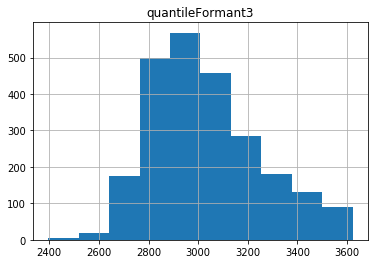

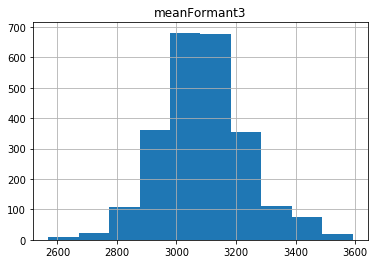

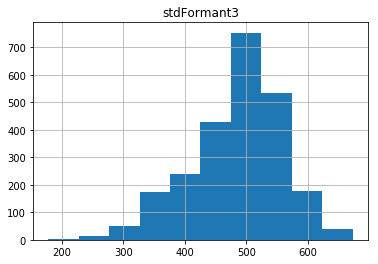

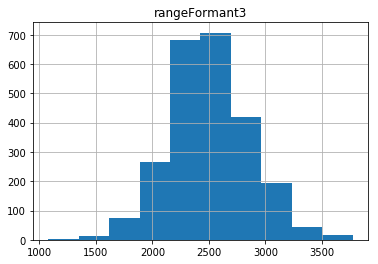

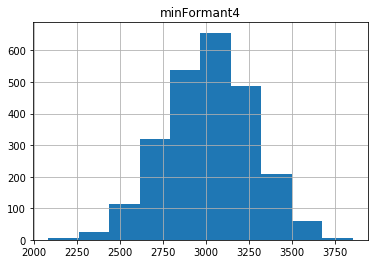

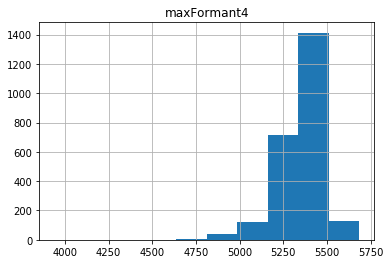

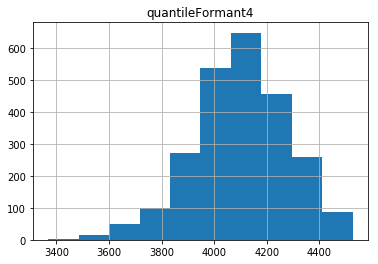

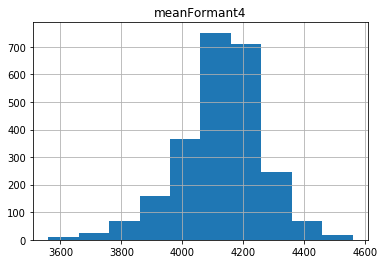

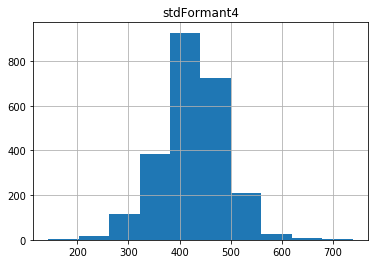

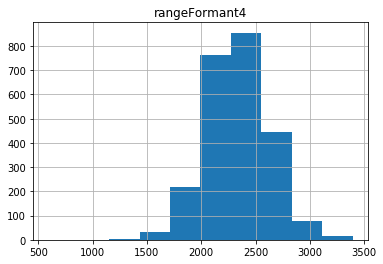

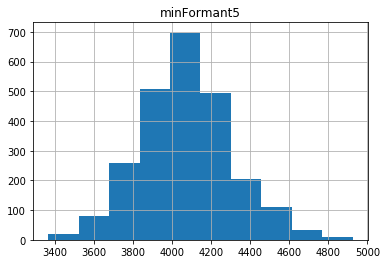

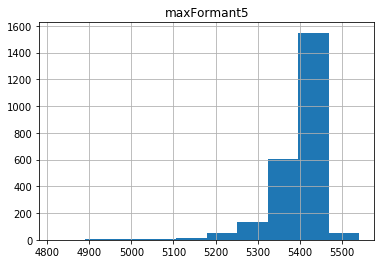

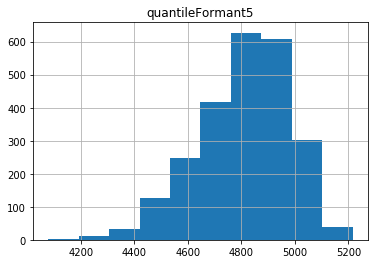

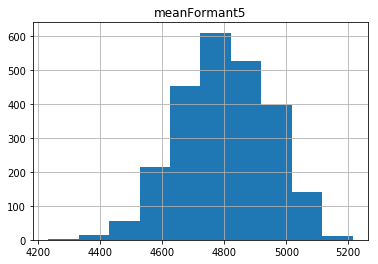

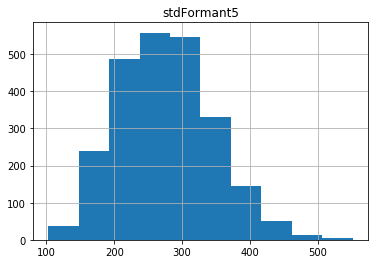

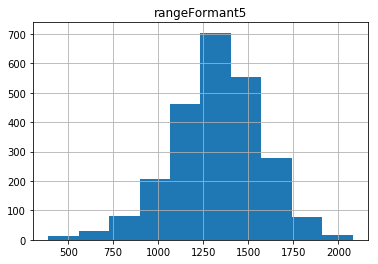

In [25]:
histogramas(X_Mezclados)

Nuevamente tras finalizar esta fase se dispone una serie de opciones para determinar con que conjunto se procedera a la eliminación de outliers

In [26]:
#opE =1
#X_MezcladosReduced = X_MezcladosNor
#X_AlemanReduced = X_AlemanNor
#X_EspanolReduced = X_EspanolNor

#opE=2
#X_MezcladosReduced = X_MezcladosNor80
#X_AlemanReduced = X_AlemanNor80
#X_EspanolReduced = X_EspanolNor80

#opE=3
#X_MezcladosReduced = X_MezcladosNorLessImportant
#X_AlemanReduced = X_AlemanNorLessImportant
#X_EspanolReduced = X_EspanolNorLessImportant

opE=4
X_MezcladosReduced = X_MezcladosNor80LessImportant
X_AlemanReduced = X_AlemanNor80LessImportant
X_EspanolReduced = X_EspanolNor80LessImportant

### Supresion de outliers

Para eliminar los outliers se define una función que calcula el primer y tercer cuartil y con ello el rango intercuartílico. En este caso, dado que el porcentaje de outliers inicial era demasiado elevado, el valor que multiplica al rango intercualtílico ha sido aumentado para ser más flexibles a la hora de determinar si un valor es atípico.

In [27]:
def deleteOutliers(data,outdata):
    lowerOutliers = np.array([False])
    upperOutliers = np.array([False])
    for i in data.columns.values:
        quartiles = data[i].quantile([0.25,0.75])
        IQR = quartiles[0.75]-quartiles[0.25]
        lowerLimit = quartiles[0.25] - 2.5*IQR
        upperLimit = quartiles[0.75] + 2.5*IQR
        lowerOutliersAux = data[i].values < lowerLimit
        upperOutliersAux = data[i].values > upperLimit
        lowerOutliers = np.logical_or(lowerOutliers, lowerOutliersAux)
        upperOutliers = np.logical_or(upperOutliers, upperOutliersAux)
    outliers = np.logical_or(lowerOutliers, upperOutliers)
    data = data.drop(np.where(outliers)[0])
    outdata = outdata.drop(np.where(outliers)[0])
    data = data.reset_index(drop=True)
    outdata = outdata.reset_index(drop=True)
    return data, outdata

In [28]:
X_MezcladosNorWithoutOutliers,y_MezcladosWithoutOutliers=deleteOutliers(X_MezcladosReduced,y_Mezclados)
X_AlemanNorWithoutOutliers, y_AlemanWithoutOutliers=deleteOutliers(X_AlemanReduced, y_Aleman)
X_EspanolNorWithoutOutliers, y_EspanolWithoutOutliers=deleteOutliers(X_EspanolReduced, y_Espanol)

# Datos de actividad

Cargamos de scores.csv los datos de los 22 pacientes a evaluar, quitando las columnas innecesarias

In [29]:
datosPacientes = pd.read_csv('csv/actividad/depresjon-dataset/data/scores.csv', na_values='--undefined--')
datosPacientes = datosPacientes.drop(columns=['number'])
datosPacientes = datosPacientes.drop(columns=['days'])
datosPacientes.head()

,gender,age,afftype,inpatient,edu,marriage,work,madrs1,madrs2
0,2,35-39,2,2,6-10,1,2,19,19
1,2,40-44,1,2,6-10,2,2,24,11
2,1,45-49,2,2,6-10,2,2,24,25
3,2,25-29,2,2,11-15,1,1,20,16
4,2,50-54,2,2,11-15,2,2,26,26


Número pacientes por generó y su clase iniciales

In [30]:
print("Pacientes género masculino:", sum(datosPacientes.gender == 2))
print("Pacientes género femenino:", sum(datosPacientes.gender == 1))
print("Pacientes con depresión:", sum(datosPacientes.afftype == 2))
print("Pacientes bipolares:", sum(datosPacientes.afftype == 1))
print("Pacientes género masculino y depresión:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 2)))
print("Pacientes género femenino y depresión:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 2)))
print("Pacientes género masculino y bipolares:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 1)))
print("Pacientes género femenino y bipolares:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 1)))

Pacientes género masculino: 12
Pacientes género femenino: 10
Pacientes con depresión: 15
Pacientes bipolares: 7
Pacientes género masculino y depresión: 8
Pacientes género femenino y depresión: 7
Pacientes género masculino y bipolares: 4
Pacientes género femenino y bipolares: 3


Seleccionamos por generos los pacientes tanto depresivos como bipolares para distribuir los datos con el mismo número de pacientes de cada tipo y género.

In [31]:
index_type1_male = datosPacientes[(datosPacientes.afftype==1) & (datosPacientes.gender==2)] 
index_type1_female = datosPacientes[(datosPacientes.afftype==1) & (datosPacientes.gender==1)]
index_type2_male = datosPacientes[(datosPacientes.afftype==2) & (datosPacientes.gender==2)]
index_type2_female = datosPacientes[(datosPacientes.afftype==2) & (datosPacientes.gender==1)]

remuve_n = 0

if(len(index_type1_male) <= len(index_type2_male)):
    remove_male = len(index_type2_male) - len(index_type1_male)
    index_type2_male = index_type2_male.sample(len(index_type1_male))   
else:
    remove_male = len(index_type1_male) - len(index_type2_male)
    index_type1_male = index_type1_male.sample(len(index_type2_male))
if(len(index_type1_female) <= len(index_type2_female)):
    remove_female = len(index_type2_female) - len(index_type1_female)
    index_type2_female = index_type2_female.sample(len(index_type1_female))
else:
    remove_female = len(index_type1_female) - len(index_type2_female)
    index_type1_female = index_type1_female.sample(len(index_type2_female))
    
remove_n = remove_male + remove_female

In [32]:
datosPacientes = pd.concat([index_type1_male, index_type1_female])
datosPacientes = pd.concat([datosPacientes, index_type2_male])
datosPacientes = pd.concat([datosPacientes, index_type2_female])
datosPacientes.head()

,gender,age,afftype,inpatient,edu,marriage,work,madrs1,madrs2
1,2,40-44,1,2,6-10,2,2,24,11
8,2,45-49,1,2,6-10,1,2,26,26
11,2,40-44,1,2,6-10,2,2,25,21
12,2,35-39,1,2,11-15,2,2,18,13
6,1,20-24,1,2,11-15,2,1,24,25


In [33]:
print("Pacientes género masculino:", sum(datosPacientes.gender == 2))
print("Pacientes género femenino:", sum(datosPacientes.gender == 1))
print("Pacientes con depresión:", sum(datosPacientes.afftype == 2))
print("Pacientes bipolares:", sum(datosPacientes.afftype == 1))
print("Pacientes género masculino y depresión:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 2)))
print("Pacientes género femenino y depresión:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 2)))
print("Pacientes género masculino y bipolares:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 1)))
print("Pacientes género femenino y bipolares:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 1)))

Pacientes género masculino: 8
Pacientes género femenino: 6
Pacientes con depresión: 7
Pacientes bipolares: 7
Pacientes género masculino y depresión: 4
Pacientes género femenino y depresión: 3
Pacientes género masculino y bipolares: 4
Pacientes género femenino y bipolares: 3


Cargamos de la carpeta condition los datos de los archivos CSV de actividad correspondiente a cada paciente que hemos seleccionado, almacenandolo en un array

In [35]:
actividadPaciente = []
for i in list(datosPacientes.index):
    path = 'csv/actividad/depresjon-dataset/data/condition/condition_' + str(i+1) + '.csv'
    actividadPaciente.append(pd.read_csv(path, na_values='--undefined--'))
datosPacientes = datosPacientes.reset_index(drop=True)

Eliminamos la columna date

In [36]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i] = actividadPaciente[i].drop(columns=['date'])

Seleccionamos el número de horas por las que vamos a agregar los datos de actividad medidos en cada paciente

In [37]:
hours = 6
#hours = 2
resample_hour = str(hours) + 'H'
n_hour_class = int(24 / hours)

Realizamos la agregación cada resample_hour horas para calcular la media (meanActivity), suma (sumActivity), desviación típica (stdActivity), varianza (varActivity), maximo (max) y minimo (min) de la actividad de cada paciente.

In [38]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i].index = pd.DatetimeIndex(actividadPaciente[i].timestamp)
    aux = actividadPaciente.copy()
    actividadPaciente[i] = round(aux[i].resample(resample_hour).mean(),2)
    actividadPaciente[i]['sumActivity'] = round(aux[i].resample(resample_hour).sum(),2)
    actividadPaciente[i]['stdActivity'] = round(aux[i].resample(resample_hour).std()['activity'],2)
    actividadPaciente[i]['varActivity'] = round(aux[i].resample(resample_hour).var()['activity'],2)
    actividadPaciente[i]['max'] = aux[i].resample(resample_hour).max()['activity']
    actividadPaciente[i]['min'] = aux[i].resample(resample_hour).min()['activity']
    actividadPaciente[i]=actividadPaciente[i].rename(columns = {'activity':'meanActivity'})

Para evitar incluir en los datos de actividad de cada paciente periodos al final donde la monitorización habia acabado y hay registros de actividad a 0, realizamos la siguiente operación para conseguir disminuir su porcentaje: Mientras que la suma de la actividad media del 20 % del final de los datos sea menor que la suma de la actividad media del 20 % del principio de los datos entre 3, vamos disminuyendo los datos un 5 % del final.

In [39]:
for j in range(0,22 - remove_n):
    while(sum(actividadPaciente[j].meanActivity[math.trunc(len(actividadPaciente[j])*0.80):]) < sum(actividadPaciente[j].meanActivity[:math.trunc((len(actividadPaciente[j])*0.20)/3)])):
        actividadPaciente[j] = actividadPaciente[j][:math.trunc(len(actividadPaciente[j])*0.95)]

Eliminamos las primeras horas hasta el primer registro que comience a las 00:00:00

In [40]:
i = 0
while(i < len(actividadPaciente)):
    while(actividadPaciente[i].index[0].hour != 0):
        actividadPaciente[i] = actividadPaciente[i][1:]
    i = i + 1

Repetimos el proceso eliminando ahora las últimas horas hasta el primer registro anterior a las 00:00:00

In [41]:
i = 0
limitHour = max(actividadPaciente[0].index.hour.values)
while(i < len(actividadPaciente)):
    while(actividadPaciente[i].index[-1].hour != limitHour):
        actividadPaciente[i] = actividadPaciente[i][:-1]
    i = i + 1

Dejamos en la columna hour solamente la hora correspondiente al periodo de actividad

In [42]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i]['hour'] = actividadPaciente[i].index
    actividadPaciente[i].hour = actividadPaciente[i].hour.astype(str).tolist()
    actividadPaciente[i] = actividadPaciente[i].reset_index(drop=True)

In [43]:
for i in range(0, 22 - remove_n):
    times = []
    for elem in actividadPaciente[i].hour:
        times.append(elem.split(' ')[1])
    actividadPaciente[i].hour = times

En las siguientes graficas podemos ver el nivel de actividad por cada uno de los campos obtenidos para cada paciente

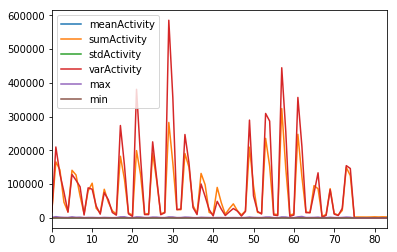

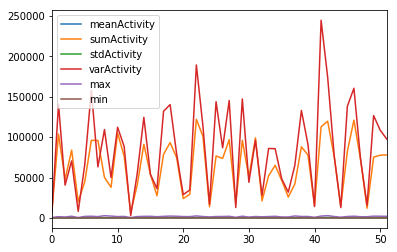

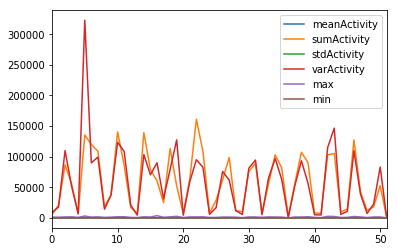

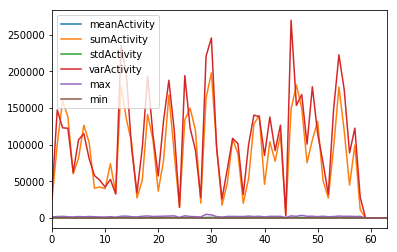

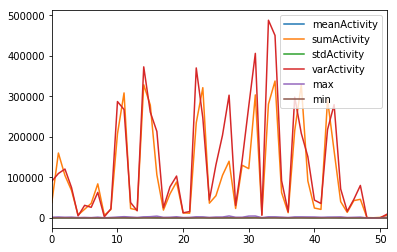

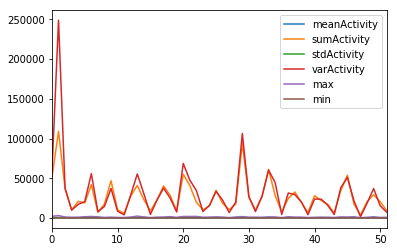

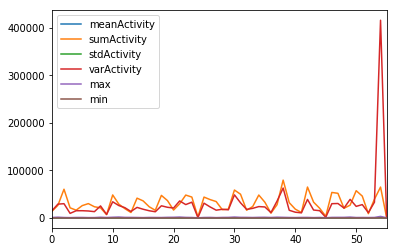

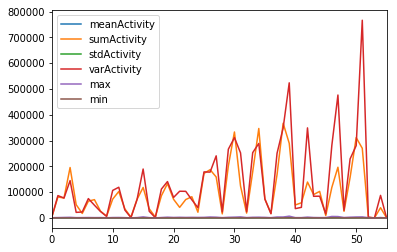

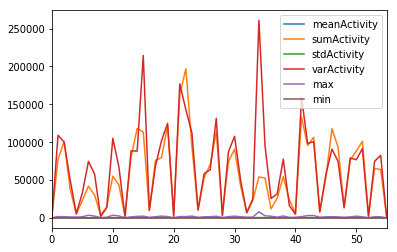

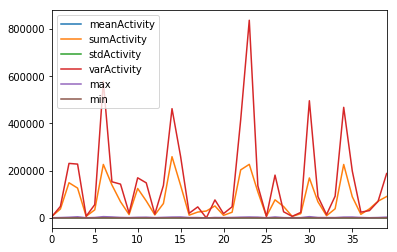

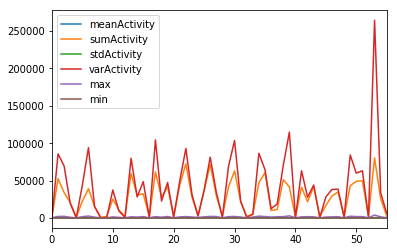

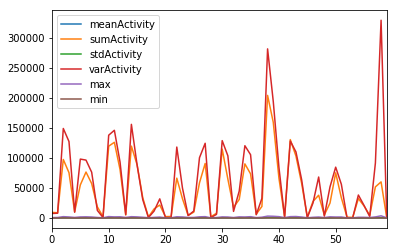

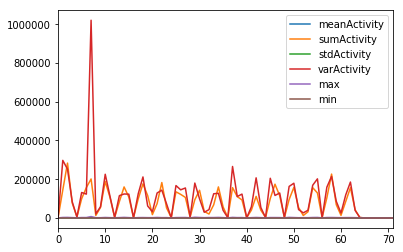

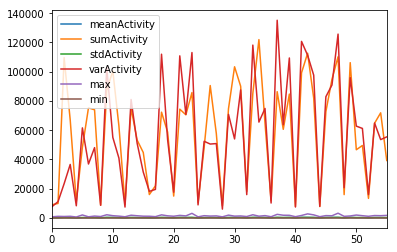

In [44]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i].plot()

Concatenamos los dataframes para que cada paciente tenga su correspondiente tabla de actividad

In [45]:
finalDF = pd.DataFrame()
for i in range(0, 22 - remove_n):
    df1 = actividadPaciente[i]
    df2 = datosPacientes[i:i+1].reindex(datosPacientes[i:i+1].index.repeat(len(actividadPaciente[i]))).reset_index(drop=True)
    auxDF = pd.concat([df1,df2], axis=1)
    finalDF = pd.concat([finalDF,auxDF]).reset_index(drop=True)

Normalizamos todas las columnas

In [46]:
le = preprocessing.LabelEncoder()
finalDF.age = le.fit_transform(finalDF.age)
finalDF.edu = le.fit_transform(finalDF.edu)
finalDF.hour = le.fit_transform(finalDF.hour)
finalDF = finalDF[~finalDF['stdActivity'].isnull()]
X_activity = finalDF.drop(['afftype'], axis=1)
scaler = MinMaxScaler()

X_activity.meanActivity = scaler.fit_transform(np.expand_dims(X_activity.meanActivity, axis=1))
X_activity.stdActivity = scaler.fit_transform(np.expand_dims(X_activity.stdActivity, axis=1))
X_activity.madrs1 = scaler.fit_transform(np.expand_dims(X_activity.madrs1, axis=1))
X_activity.madrs2 = scaler.fit_transform(np.expand_dims(X_activity.madrs2, axis=1))
X_activity.varActivity = scaler.fit_transform(np.expand_dims(X_activity.varActivity, axis=1))
X_activity.sumActivity = scaler.fit_transform(np.expand_dims(X_activity.sumActivity, axis=1))
X_activity['max'] = scaler.fit_transform(np.expand_dims(X_activity['max'], axis=1))
X_activity['min'] = scaler.fit_transform(np.expand_dims(X_activity['min'], axis=1))
y_activity = finalDF.afftype

/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jose/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dty

In [47]:
X_activity.head()

,meanActivity,sumActivity,stdActivity,varActivity,max,min,hour,gender,age,inpatient,edu,marriage,work,madrs1,madrs2
0,0.051847,0.051849,0.132935,0.017670,0.189375,0.037037,0,2,3,2,2,2,2,0.6875,0.0
1,0.451566,0.451569,0.453475,0.205633,0.467000,0.049383,1,2,3,2,2,2,2,0.6875,0.0
2,0.388030,0.388034,0.357050,0.127485,0.275625,0.049383,2,2,3,2,2,2,2,0.6875,0.0
3,0.127023,0.127023,0.275034,0.075642,0.189375,0.037037,3,2,3,2,2,2,2,0.6875,0.0
4,0.049228,0.049228,0.129392,0.016743,0.167000,0.037037,0,2,3,2,2,2,2,0.6875,0.0


Eliminamos las columnas que hacen referencia a los datos del paciente y que no tienen relacion con la actividad

In [48]:
gender = X_activity.gender[X_activity.hour==0].reset_index(drop=True)
age = X_activity.age[X_activity.hour==0].reset_index(drop=True)
inpatient = X_activity.inpatient[X_activity.hour==0].reset_index(drop=True)
edu = X_activity.edu[X_activity.hour==0].reset_index(drop=True)
marriage = X_activity.marriage[X_activity.hour==0].reset_index(drop=True)
work = X_activity.work[X_activity.hour==0].reset_index(drop=True)
madrs1 = X_activity.madrs1[X_activity.hour==0].reset_index(drop=True)
madrs2 = X_activity.madrs2[X_activity.hour==0].reset_index(drop=True)


X_activity = X_activity.drop(['age'], axis=1)
X_activity = X_activity.drop(['inpatient'], axis=1)
X_activity = X_activity.drop(['edu'], axis=1)
X_activity = X_activity.drop(['marriage'], axis=1)
X_activity = X_activity.drop(['work'], axis=1)
X_activity = X_activity.drop(['madrs1'], axis=1)
X_activity = X_activity.drop(['madrs2'], axis=1)
X_activity = X_activity.drop(['gender'], axis=1)

Graficas de días completos pacientes depresivos (Realizar con agregaciónes de 1 hora)

In [49]:
#X_activity[y_activity==2][:23].drop(columns=['hour','sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][24:47].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][48:71].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][72:95].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])

Graficas de días completos pacientes bipolares (Realizar con agregaciónes de 1 hora)

In [50]:
#X_activity[y_activity==1][:23].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][24:47].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity', 'stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][48:71].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][72:95].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])

Ponemos las filas correspondientes a un mismo día en columnas, para que cada fila represente un día entero de actividad de los pacientes, enumerandolas según el número de particiones que hagamos.

In [51]:
columns = X_activity.drop(['hour'], axis=1).columns.values
X_activity_list = []
X_activity_final = X_activity[X_activity.hour==0].drop(['hour'], axis=1).reset_index(drop=True)
y_activity_final = y_activity[X_activity.hour==0].reset_index(drop=True)
X_activity_list.append(X_activity_final)
for i in range(0, n_hour_class - 1):
    X_activity_list.append(X_activity[X_activity.hour==i + 1].reset_index(drop=True))
    X_activity_list[-1] = X_activity_list[-1].drop(['hour'], axis=1)

for j in range(0, n_hour_class - 1):
    X_activity_list[j+1].columns = list(columns + str(j + 1))
    X_activity_final = pd.concat([X_activity_final, X_activity_list[j+1]], axis=1)

Añadimos las columnas con información referida a los pacientes que deseemos.

In [52]:
X_activity_final = pd.concat([X_activity_final, gender], axis=1)
#X_activity_final = pd.concat([X_activity_final, age], axis=1)
#X_activity_final = pd.concat([X_activity_final, inpatient], axis=1)
#X_activity_final = pd.concat([X_activity_final, edu], axis=1)
#X_activity_final = pd.concat([X_activity_final, marriage], axis=1)
#X_activity_final = pd.concat([X_activity_final, work], axis=1)
#X_activity_final = pd.concat([X_activity_final, madrs1], axis=1)
#X_activity_final = pd.concat([X_activity_final, madrs2], axis=1)

Eliminamos las columnas con datos referidos a la actividad que deseemos

In [53]:
for elem in [#'meanActivity', 
             #'sumActivity', 
             #'stdActivity', 
             #'varActivity', 
             #'max',
             'min'
            ]:
    X_activity_final = X_activity_final.drop([elem], axis=1)

for i in range(1, n_hour_class):
    #X_activity_final = X_activity_final.drop(['meanActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['sumActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['stdActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['varActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['max' + str(i)], axis=1)
    X_activity_final = X_activity_final.drop(['min' + str(i)], axis=1)

Comparación medias de dos tipos de pacientes por tramos del día

In [54]:
activity = pd.concat([X_activity_final, y_activity_final], axis=1)
prueba1 = []
prueba2 = []
resul = []
for i in range(0, n_hour_class):
    if i == 0:
        aux1 = activity[activity['afftype'] == 1]
        aux2 = activity[activity['afftype'] == 2]
        prueba1.append(aux1['meanActivity'].mean())
        prueba2.append(aux2['meanActivity'].mean())
    else:
        aux1 = activity[activity['afftype'] == 1]
        aux2 = activity[activity['afftype'] == 2]
        prueba1.append(aux1['meanActivity' + str(i)].mean())
        prueba2.append(aux2['meanActivity' + str(i)].mean())
    resul.append([prueba1[i] - prueba2[i]])

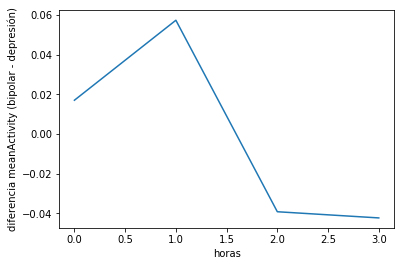

In [55]:
plt.plot(range(0, n_hour_class), resul)
plt.ylabel('diferencia meanActivity (bipolar - depresión)')
plt.xlabel('horas')
plt.show()

In [56]:
prueba1 = []
prueba2 = []
resul = []
for i in range(0, n_hour_class):
    if i == 0:
        aux1 = X_activity_final[X_activity_final.gender==1]
        aux2 = X_activity_final[X_activity_final.gender==2]
        prueba1.append(aux1['meanActivity'].mean())
        prueba2.append(aux2['meanActivity'].mean())
    else:
        aux1 = X_activity_final[X_activity_final.gender==1]
        aux2 = X_activity_final[X_activity_final.gender==2]
        prueba1.append(aux1['meanActivity' + str(i)].mean())
        prueba2.append(aux2['meanActivity' + str(i)].mean())
    resul.append([prueba1[i] - prueba2[i]])

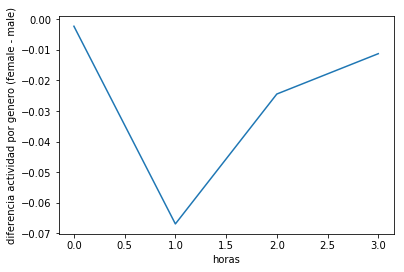

In [57]:
plt.plot(range(0, n_hour_class), resul)
plt.ylabel('diferencia actividad por genero (female - male)')
plt.xlabel('horas')
plt.show()


Total días monitorizados por tipo paciente

In [58]:
print("Total días medidos", len(X_activity_final))
print("Total días medidos pacientes bipolares", len(X_activity_final[y_activity_final==1]))
print("Total días medidos pacientes depresión", len(X_activity_final[y_activity_final==2]))

Total días medidos 202
Total días medidos pacientes bipolares 103
Total días medidos pacientes depresión 99


# Selección de datos para las pruebas

Finalmente se decide con que conjunto de datos se procede a entrenar y validar los algoritmos

In [ ]:
#Datos de audio
#X_Train, y_Train, mean, std = X_MezcladosReduced,y_Mezclados, meanMezclados, stdMezclados
#X_Train, y_Train, mean, std = X_AlemanReduced,y_Aleman, meanAleman, stdAleman
#X_Train, y_Train, mean, std = X_EspanolReduced,y_Espanol, meanEspanol, stdEspanol
#X_Train, y_Train, mean, std = X_MezcladosNorWithoutOutliers,y_MezcladosWithoutOutliers, meanMezclados, stdMezclados
#X_Train, y_Train, mean, std = X_AlemanNorWithoutOutliers,y_AlemanWithoutOutliers, meanAleman, stdAleman
X_Train, y_Train, mean, std = X_EspanolNorWithoutOutliers,y_EspanolWithoutOutliers, meanEspanol, stdEspanol

#En caso de utilizar un metodo de normalización que se realice mediante un scaler
#scaler = scalerM
#scaler = scalerA
scaler = scalerE

#Datos de actividad
#X_Train, y_Train = X_activity_final, y_activity_final

Para agregar las 6 clases en 3, una con las emociones alegria, ira y miedo que representaría la euforia o mania, otra con las emociones tristeza y asco que representaría la depresión y otra neutral, se modifican las etiquetas para tener 3: 0-euforia, 1-depresion, 2-neutral

In [ ]:
y_Train[y_Train==2]=0 #El miedo pasa a euforia
y_Train[y_Train==3]=1 #El asco pasa a depresion
y_Train[y_Train==4]=0 #La ira pasa a euforia
y_Train[y_Train==5]=2 #Para tener las etiquetas en un orden creciente y continuo la etiqueta neutral pasa a ser un 2

## Pruebas para determinar valores adecuados para cada algoritmo

In [ ]:
bestNumberOfEstimatorsGBC = 0
maxValueGBC = 0.0
for i in range(1, 101, 10):
    ini = time.time()
    model = GradientBoostingClassifier(random_state=1, n_estimators=i)
    scores = cross_val_score(model, X_Train, y_Train, cv=10, scoring='accuracy')
    fin = time.time()
    if scores.mean() > maxValueGBC:
        maxValueGBC = scores.mean()
        bestNumberOfEstimatorsGBC = i
    print('Numero estimadores' , i)
    print(scores.mean())
    print('Tiempo estimado:', fin-ini, 'segundos')

In [ ]:
bestNumberOfEstimatorsRFC = 0
maxValueRFC = 0
for i in range(1, 101, 10):
    ini = time.time()
    model = RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(model, X_Train, y_Train, cv=10, scoring='accuracy')
    fin = time.time()
    if scores.mean() > maxValueRFC:
        maxValueRFC = scores.mean()
        bestNumberOfEstimatorsRFC = i
    print('Numero estimadores' , i)
    print(scores.mean())
    print('Tiempo estimado:', fin-ini, 'segundos')

In [ ]:
bestNumNeuronas1 = 0
bestAlpha = 0
bestLearning_rate = 0
maxValueMLP = 0
for capa1 in range(10, 100, 10):
    for j in [0.1, 0.01, 0.001, 1,10,100]:
        ini = time.time()
        model = MLPClassifier(hidden_layer_sizes=[capa1], activation='relu',solver='lbfgs',alpha=j,learning_rate='adaptive')
        scores = cross_val_score(model, X_Train, y_Train, cv=10, scoring='accuracy')
        fin = time.time()
        if scores.mean() > maxValueMLP:
            maxValueMLP = scores.mean()
            bestNumNeuronas1 = capa1
            bestAlpha = j
        print('Neuronas capa oculta: ',capa1,'alpha: ',j,':  ',scores.mean())
        print('Tiempo estimado:', fin-ini, 'segundos')

In [ ]:
ini = time.time()
model = GaussianNB([0.17,0.17,0.17,0.17,0.16,0.16])
scores = cross_val_score(model,X_Train,y_Train,cv=10,scoring='accuracy')
fin = time.time()
print(scores.mean())

In [ ]:
mejorC = 0
mejorGamma = 0
maxPredictSVM = 0.0
for i in [1, 10, 100, 1000]:
    for j in [0.1, 0.01, 0.001, 1]:
        ini = time.time()
        model = SVC(kernel='rbf', C=i, gamma=j)
        scores = cross_val_score(model, X_Train, y_Train, cv=10, scoring='accuracy')
        fin = time.time()
        if scores.mean() > maxPredictSVM:
            maxPredictSVM = scores.mean()
            mejorC = i
            mejorGamma = j
        print('C =', i, 'gamma =', j, ':', scores.mean())
        print('Tiempo estimado:', fin-ini, 'segundos')

# Creacion y entrenamiento de algoritmos

In [ ]:
#modelRandom = RandomForestClassifier(n_estimators=bestNumberOfEstimatorsRFC)
#modelSVC = SVC(kernel='rbf', C=mejorC, gamma=mejorGamma)
#modelGBC = GradientBoostingClassifier(random_state=1, n_estimators=bestNumberOfEstimatorsGBC)
#modelMLP =  MLPClassifier(hidden_layer_sizes=[bestNumNeuronas1], activation='relu',solver='lbfgs',alpha=bestAlpha,learning_rate='adaptative')
modelMLP =  MLPClassifier(hidden_layer_sizes=[20], activation='relu',solver='lbfgs',alpha=0.1,learning_rate='adaptive')
#modelNB = GaussianNB([0.17,0.17,0.17,0.17,0.16,0.16])
#modelRandom.fit(X_Train,y_Train)
#modelSVC.fit(X_Train,y_Train)
#modelGBC.fit(X_Train,y_Train)
#modelMLP.fit(X_Train,y_Train)
#modelNB.fit(X_Train,y_Train)

## Pruebas

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Train, y_Train, random_state=0)

#Para cuando los datos de prueba son audios
#class_names = ['Euforia', 'Depresion', 'Neutral']
class_names = ['Alegría', 'Tristeza', 'Miedo','Asco','Ira','Neutral']

#Para cuando los datos de prueba son de actividad
#class_names = ['bipolar', 'unipolar_depressive']

#y_pred = modelSVC.fit(X_train, y_train).predict(X_test)
#y_pred = modelRandom.fit(X_train, y_train).predict(X_test)
#y_pred = modelGBC.fit(X_train, y_train).predict(X_test)
#y_pred = modelNB.fit(X_train,y_train).predict(X_test)
y_pred = modelMLP.fit(X_train,y_train).predict(X_test)


precision, recall, f1Score, _ =precision_recall_fscore_support(y_test,y_pred)

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print('Precision: ',precision)
print('Recall: ',recall)
print('F1 Score: ',f1Score)

# Pruebas de audio

Por ultimo para realizar pruebas será necesario tratar los datos de prueba tal cuál se han tratado los datos de entrenamiento, por ello la función posee un parametro que indica que proceso se ha seguido y por lo tanto como a de tratar estos datos de prueba

In [ ]:
def transformarDatos(datosPrueba, normalizacion, eliminacion):
    datosPrueba = deleteNAWithMean(datosPrueba,mean)
    if normalizacion == 1 or normalizacion == 4:
        datosPrueba = scaler.transform(datosPrueba)
    elif normalizacion == 2:
        datosPrueba = normalizarPrueba(datosPrueba,mean,std)
    else:
        datosPrueba = normalize(datosPrueba, norm=norm,axis=0)
    
    if eliminacion == 2:
        datosPrueba = datosPrueba.drop(['meanEnergy','minEnergy','rangeEnergy','stdEnergy','rangeAmplitude','minMFCC1','stdMFCC1','rangeMFCC2','rangeMFCC4','rangeMFCC12','maxPitch','stdPitch','quantileFormant1','quantileFormant2','rangeFormant2','quantileFormant3','quantileFormant4','rangeFormant4','rangeFormant5','quantileFormant5','stdAmplitude','articulationRate','meanIntensity'], axis=1)
    elif eliminacion == 3:
        datosPrueba = datosPrueba.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant2','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
    elif eliminacion ==4 :
        datosPrueba = datosPrueba.drop(['minFormant1','maxFormant3','minHarmonicity','maxFormant5','rangeFormant1','maxMFCC6','maxFormant2','minFormant2','maxMFCC4','maxFormant4'], axis=1)
    return datosPrueba

In [ ]:
def probar(filename,opcionNormalizacion,opcionEliminacion):
    datosPrueba = pd.read_csv(filename, na_values='--undefined--')
    nombres = datosPrueba.iloc[:,0]
    datosPrueba = datosPrueba.iloc[:,1:]
    transformarDatos(datosPrueba,opcionNormalizacion,opcionEliminacion)
    datosPrueba = pd.DataFrame(datosPrueba)
    resultados = pd.DataFrame(index = nombres)
    resultados['RandomForest'] = modelRandom.predict(datosPrueba)
    resultados['SVM'] = modelSVC.predict(datosPrueba)
    resultados['GradientBoosting'] = modelGBC.predict(datosPrueba)
    resultados['NN'] = modelMLP.predict(datosPrueba)
    resultados['NB'] = modelNB.predict(datosPrueba)
    resultados.replace(0,"Alegria",inplace=True)
    resultados.replace(1,"Tristeza",inplace=True)
    resultados.replace(2,"Miedo",inplace=True)
    resultados.replace(3,"Asco",inplace=True)
    resultados.replace(4,"Ira",inplace=True)
    resultados.replace(5,"Neutral",inplace=True)
    print(resultados)

In [ ]:
probar('sonidosPrueba.csv',opN,opE)